In [2]:
!pip -q install opendatasets
!pip -q install pandas
!pip -q install wordcloud
!pip -q install --upgrade huggingface-hub
!pip -q install --upgrade plotly

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing

import os

In [4]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
od.download("https://www.kaggle.com/datasets/vsmolyakov/fasttext")
od.download("https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation")

Skipping, found downloaded files in "./imdb-dataset-of-50k-movie-reviews" (use force=True to force download)
Skipping, found downloaded files in "./fasttext" (use force=True to force download)
Skipping, found downloaded files in "./glove-global-vectors-for-word-representation" (use force=True to force download)


- username	"  "
- key	"  "

huggingface-cli login #type in cli, command prompt.

#

In [5]:
import io

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

import re, csv, math, codecs

from wordcloud import WordCloud
from bs4 import BeautifulSoup

from sklearn import model_selection
from sklearn import metrics

import string
from string import punctuation

import torch
import torch.nn as nn
import tensorflow as tf

### Initializing Dataframe

In [6]:
# Making dataframe
df = pd.read_csv('/notebooks/notebooks/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

### Basic data analysis

In [7]:
df.head(20) # .head() shows first 5 samples. Adjustable.

# Looking into first 20 reviews, there are html, special char, and numbers.

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [8]:
df.isna().sum() # .isna() returns True/False if there is NaN. Joined with .sum() show number of NaN values in features.

# The imdb dataset does not have NaN values.

review       0
sentiment    0
dtype: int64

In [9]:
df.describe() # describe() generate statistics of a dataframe

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Double checking for NaN values in 'count' row. There are None.

In 'unique' row, there are 49,582 unique reviews.
- There are 418 identical reviews. (50,000 - 49,582)
- sentiment column has '2' unique values. Confirming that there are only positive and negative.

### WordCloud, before data proprocessing.

In [10]:
# Convert sentiment columns to numerical values
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0)

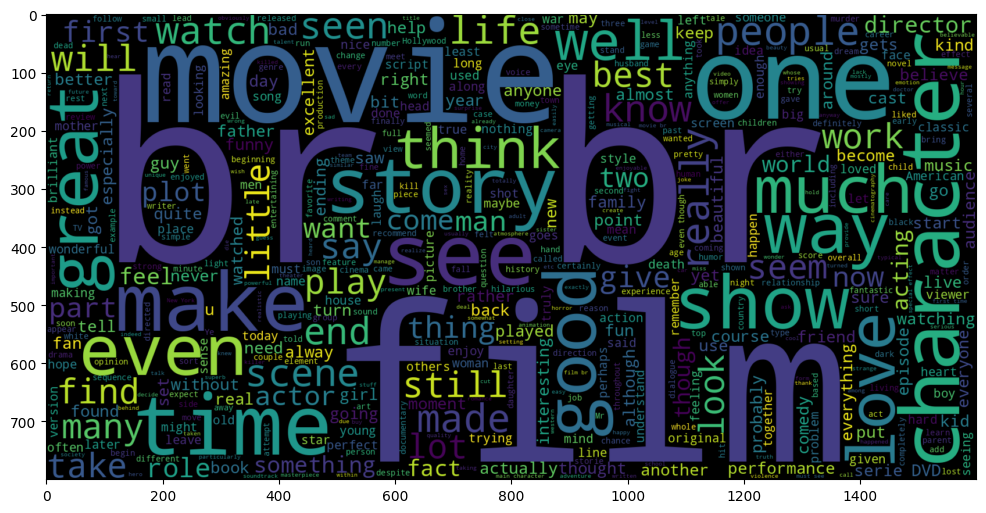

In [11]:
plt.figure(figsize=(12,12))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(" ".join(df[df.sentiment == 1].review))

plt.imshow(wordcloud, interpolation='bilinear') # interpolation is for the quality and flexiblity of wordcloud when resized.

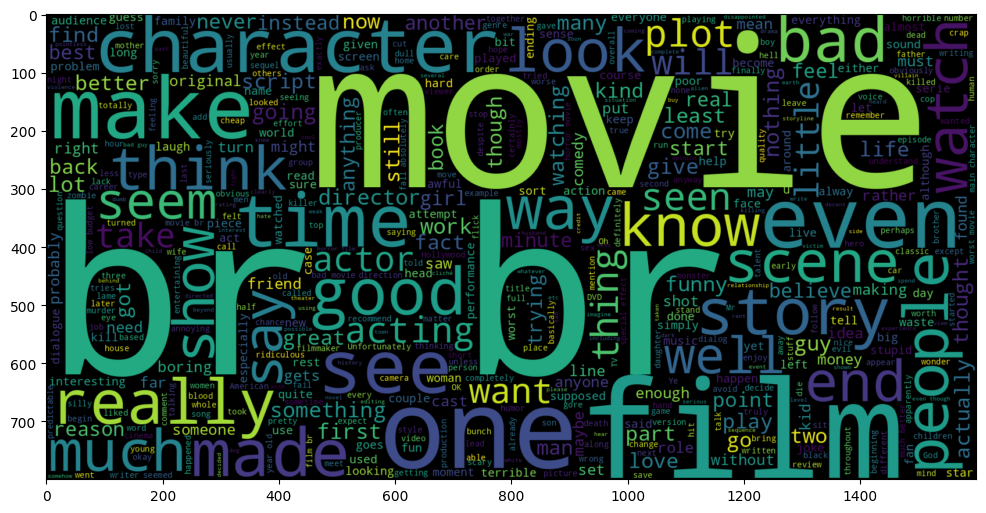

In [12]:
plt.figure(figsize=(12,12))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(" ".join(df[df.sentiment == 0].review))

plt.imshow(wordcloud, interpolation='bilinear')

WordCloud is a nice tool to get a overview on common vocabs. Also, a detective tool to see if there are any uncommon words.

Shown above, 'br br' stands out on both positive and negative sentiments. Let's see where 'br br' appear in reviews.

In [13]:
df.iloc[1] # prints a row in index 1.

review       A wonderful little production. <br /><br />The...
sentiment                                                    1
Name: 1, dtype: object

I can identify that 'br br' is a html. They hold no sentimental values, and will interfere with model's performance.

### Data Collection and Cleaning

- Beautiful Soup
- special char, URL, stopwords.

In [14]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
def strip_html(text):
    # Extracts information from html format.
    soup = BeautifulSoup(text, features = 'html.parser')
    return soup.get_text()

#squre brackets
def remov_btwn_sqbrkts(text):
    return re.sub('\[[^]]*\]', '', text)
    # \[ matches '['
    # [^]]* matches any char except the ones inside the square brackets. '[' is allowed
    # \] matches ']'
    # Contents in brackets along with the brackets are replaced with empty string.
    
# Removing URL
def remov_url(text):
    return re.sub(r'http\S+', '', text)
    # https is the most common url begginings.
    # \S+ after http, matches one or more non-whitespace chars
    
# Removing the stopwords from txt
def remov_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    # stopwords are like 'the', 'is', etc.
    # strip() turns string into a list of its words. Depending on the method parameter, its split based on that. eg. split(',') ... split by commas
    # for loop iterating over text.split() with 'i'
    # checks if 'i' is in stopwords 'if i.strip().lower() not in stop'
    # Also checks if 'i' is lowercase and alphabelts 'and i.strip().lower().isalpha()'
    
    return " ".join(final_text)

In [16]:
def clean_text(text):
    text = strip_html(text)
    text = remov_btwn_sqbrkts(text)
    text = remov_url(text)
    text = remov_stopwords(text)
    return text

df['review'] = df['review'].apply(clean_text)

/usr/local/lib/python3.9/dist-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [17]:
df.iloc[1]

review       wonderful little filming technique fashion giv...
sentiment                                                    1
Name: 1, dtype: object

I can confirm that the dataset has been cleaned successfully.

### WordCloud after data cleaning

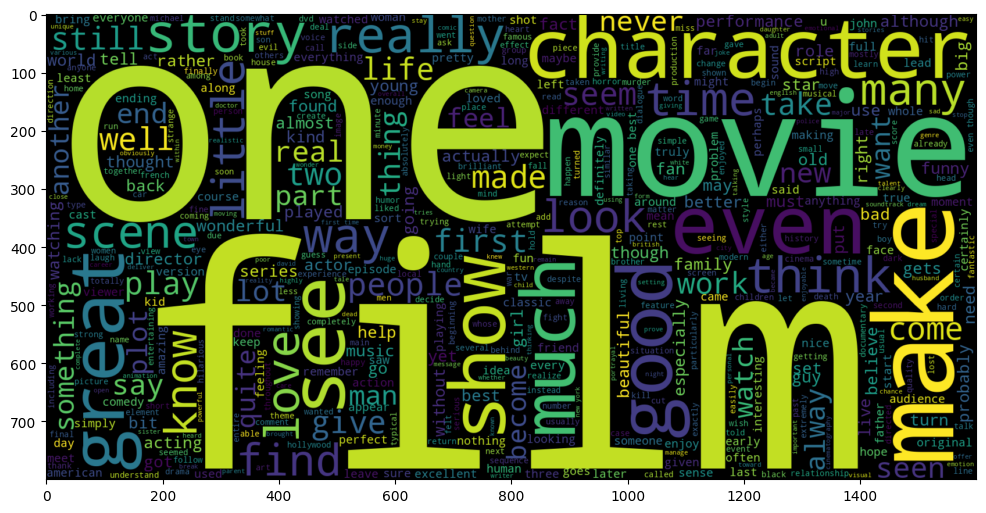

In [18]:
plt.figure(figsize=(12,12))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(" ".join(df[df.sentiment == 1].review))

plt.imshow(wordcloud, interpolation='bilinear')

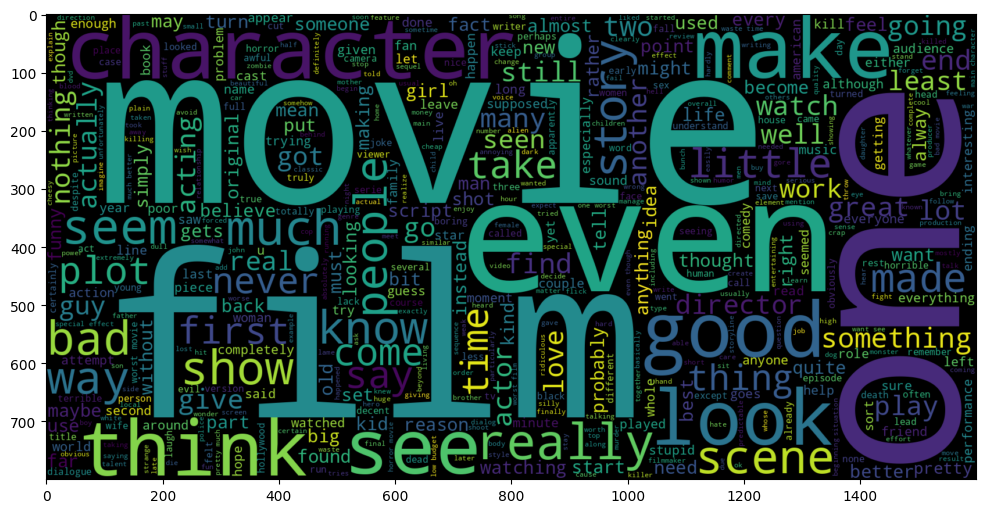

In [19]:
plt.figure(figsize=(12,12))
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(" ".join(df[df.sentiment == 0].review))

plt.imshow(wordcloud, interpolation='bilinear')

'br br' is replaced and words with more sentimental values are standing out.

### fastText and GloVe

In [20]:
fasttext_embedding = {}

f = codecs.open('/notebooks/notebooks/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f): # iterates each line in the file.
    values = line.rstrip().rsplit(' ') # the line is split by the space character.
    
    # represents the first element in the list of values obtained by splitting the line. 
    # this first element is typically the word itself. So, word is assigned the value of the word extracted from the line.
    word = values[0]
    
    # The np.asarray() function converts this sublist into a NumPy array with a data type of 'float32'
    coefs = np.asarray(values[1:], dtype='float32') # values[1:] represents second element of the original list.
    
    fasttext_embedding[word] = coefs # The word and its vector are stored in the fasttext_embedding dictionary.
f.close()


111052it [00:08, 13162.44it/s]


In [21]:
fasttext_embedding['hello'].shape # for defining the dimension for matrix.

(300,)

In [22]:
# Load Standford Glove embedding.
glove = pd.read_csv('/notebooks/notebooks/glove-global-vectors-for-word-representation/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)

# converts the Glove DataFrame to a dictionary. dictionary where each key is a word from the Glove embeddings.
glove_embedding = {key: val.values for key, val in glove.T.items()} 

glove_embedding['hello'].shape

(100,)

### Modelling

In [23]:
## Cross validation 
# create new column "kfold" and assign a random value
df['kfold'] = -1

# shuffled randomly. resets the index of the DataFrame after shuffling.
df = df.sample(frac=1).reset_index(drop=True)

# This array will be used to ensure that each fold maintains the same distribution of sentiment labels.
y = df.sentiment.values

# Stratified K-Fold cross-validator is initialized with 5 splits.
kf = model_selection.StratifiedKFold(n_splits=5)

# ensures that every row in the DataFrame is associated with a specific fold. 
# allowing for consistent and organized cross-validation
for fold, (train_, valid_) in enumerate(kf.split(X=df, y=y)):
    df.loc[valid_, 'kfold'] = fold

df.head(3)

,review,sentiment,kfold
0,premise awaited sequel really good huge succes...,0,0
1,celebration earth day disney released film sto...,1,0
2,wandered movie watching left quite huge fan wa...,0,0


In [24]:
class IMDBDataset:
    def __init__(self, reviews, targets):
        # initialization of reviews and targets
        self.reviews = reviews # Numpy array
        self.target = targets # Vector array
    
    def __len__(self):
        # return length of dataset
        return len(self.reviews)
    
    def __getitem__(self, index):
        # lets you pick out a specific review and its target using an index.
        review = torch.tensor(self.reviews[index,:], dtype = torch.long)
        target = torch.tensor(self.target[index], dtype = torch.float)
        
        # returns as dictionary
        return {'review': review,
                'target': target}

In [25]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        
        super(LSTM, self).__init__() # Calls the constructor of the superclass (nn.Module).
        
        num_words = embedding_matrix.shape[0] # Number of words
        embedding_dim = embedding_matrix.shape[1] # Dimension of the word embeddings.
        
        # Define an input embedding layer
        self.embedding = nn.Embedding( num_embeddings=num_words, embedding_dim=embedding_dim)
        
        # Sets the weights of the embedding layer from 'embedding_matrix'
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        
        # Using pretrained embedding, GloVe and Fastext, no graient training.
        self.embedding.weight.requires_grad = False
        
        # LSTM configuration
        self.lstm = nn.LSTM( embedding_dim, 128,bidirectional=True, batch_first=True,)
        self.out = nn.Linear(512, 1)
    
    def forward(self, x):
        
        # Takes the tokenized sequences and passes it through the embedding layer.
        x = self.embedding(x)
        hidden, _ = self.lstm(x)
        
        # mean pooling and max pooling on the LSTM output along the sequence dimension(1).
        avg_pool= torch.mean(hidden, 1)
        max_pool, index_max_pool = torch.max(hidden, 1)
        
        # Concatenates the results of mean pooling and max pooling(512).
        out = torch.cat((avg_pool, max_pool), 1)
        
        # Pass the vector through the linear layer for final output.
        out = self.out(out)
        return out

In [26]:
def train(data_loader, model, optimizer, device):
    # set model to training mode
    model.train()
    
    # iterate batches of reviews and its targets
    for data in data_loader:
        reviews = data['review']
        targets = data['target']
        
        # Device selection
        reviews = reviews.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.float)
        
        # clear the gradient for new batches
        optimizer.zero_grad()
        
        # make predictions
        predictions = model(reviews)
        # caculate the losses
        loss = nn.BCEWithLogitsLoss()(predictions, targets.view(-1,1))
        # Backpropagation
        loss.backward()
        #single optimization step.
        optimizer.step()

In [27]:
def evaluate(data_loader, model, device):
    
    # Initialization
    final_predictions = []
    final_targets = []
    
    # Set model to evaluation mode
    model.eval()
    # turn off gradient calculation
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            targets = data['target']
            
            reviews = reviews.to(device, dtype = torch.long)
            targets = targets.to(device, dtype=torch.float)
            
            # make prediction
            predictions = model(reviews)
            
            # move prediction and target to cpu
            predictions = predictions.cpu().numpy().tolist()
            targets = data['target'].cpu().numpy().tolist()
            
            # add predictions to final_prediction
            final_predictions.extend(predictions)
            final_targets.extend(targets)
    return final_predictions, final_targets

### Configs

In [28]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5

In [29]:
def create_embedding_matrix(word_index, embedding_dict=None, d_model=100):
    # Initializes a numpy array filled with zeros
    embedding_matrix = np.zeros((len(word_index) + 1, d_model))
    # loop over all the words. assign the appropriate embedding vector
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

### Train with fastText

In [30]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.review.values.tolist())

In [31]:
print('Load fasttext embedding')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=fasttext_embedding, d_model=300)

# I just run 1 fold to reduce the time. You can try more fold to get better generalization
for fold in range(1):
    # STEP 2: cross validation
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    # STEP 3: pad sequence
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # zero padding
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
    
    # STEP 4: initialize dataset class for training
    train_dataset = IMDBDataset(reviews=xtrain, targets=train_df.sentiment.values)
    
    # STEP 5: Load dataset to Pytorch DataLoader
    # after we have train_dataset, we create a torch dataloader to load train_dataset class based on specified batch_size
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    # initialize dataset class for validation
    valid_dataset = IMDBDataset(reviews=xtest, targets=valid_df.sentiment.values)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # STEP 6: Running 
    device = torch.device('cuda')
    # feed embedding matrix to lstm
    model_fasttext = LSTM(embedding_matrix)
    # set model to cuda device
    model_fasttext.to(device)
    # initialize Adam optimizer
    optimizer = torch.optim.Adam(model_fasttext.parameters(), lr=1e-3)
    
    print('training model')
   
    for epoch in range(EPOCHS):
        #train one epoch
        train(train_data_loader, model_fasttext, optimizer, device)
        #validate
        outputs, targets = evaluate(valid_data_loader, model_fasttext, device)
        # threshold
        outputs = np.array(outputs) >= 0.5
        # calculate accuracy
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'FOLD:{fold}, epoch: {epoch}, accuracy_score: {accuracy}')

Load fasttext embedding
training model
FOLD:0, epoch: 0, accuracy_score: 0.849
FOLD:0, epoch: 1, accuracy_score: 0.8617
FOLD:0, epoch: 2, accuracy_score: 0.868
FOLD:0, epoch: 3, accuracy_score: 0.8672
FOLD:0, epoch: 4, accuracy_score: 0.8642


### Training with GloVe

In [ ]:
print('Load Glove embedding')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=glove_embedding, d_model=100)

for fold in range(1):
    # STEP 2: cross validation
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    # STEP 3: pad sequence
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # zero padding
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
    
    # STEP 4: initialize dataset class for training
    train_dataset = IMDBDataset(reviews=xtrain, targets=train_df.sentiment.values)
    
    # STEP 5: Load dataset to Pytorch DataLoader
    # after we have train_dataset, we create a torch dataloader to load train_dataset class based on specified batch_size
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    # initialize dataset class for validation
    valid_dataset = IMDBDataset(reviews=xtest, targets=valid_df.sentiment.values)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # STEP 6: Running 
    device = torch.device('cuda')
    # feed embedding matrix to lstm
    model_glove = LSTM(embedding_matrix)
    # set model to cuda device
    model_glove.to(device)
    # initialize Adam optimizer
    optimizer = torch.optim.Adam(model_glove.parameters(), lr=1e-3)
    
    print('training model')
   
    for epoch in range(EPOCHS):
        #train one epoch
        train(train_data_loader, model_glove, optimizer, device)
        #validate
        outputs, targets = evaluate(valid_data_loader, model_glove, device)
        # threshold
        outputs = np.array(outputs) >= 0.5
        # calculate accuracy
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'FOLD:{fold}, epoch: {epoch}, accuracy_score: {accuracy}')

Load Glove embedding
training model
FOLD:0, epoch: 0, accuracy_score: 0.8334
FOLD:0, epoch: 1, accuracy_score: 0.8459
FOLD:0, epoch: 2, accuracy_score: 0.8462
FOLD:0, epoch: 3, accuracy_score: 0.8455
